In [905]:
import numpy as np
import matplotlib.pyplot as plt

In [906]:
# defined params
RIGHT = 0
LEFT = 1

In [907]:
# mechanical params
g = 9.81 # m/s^2
m = 1.2 # kg

In [908]:
# robot initial settings
z0 = 158 * 0.001
z_flight = 0.04
foot_dist_y_base = 0.03
foot_dist_x_max = 0.12

T_sup_base = 0.6
T_sup_min = 0.3

Tc = np.sqrt(z0 / g)

vy_max = 0.05

In [909]:
# basic state calculation
def calc_basic_passing_com_vel(p, T_sup):
    return (p/Tc) * ( np.sinh(T_sup/Tc) / ( 1 - np.cosh(T_sup/Tc)))    
def calc_basic_unpassing_com_vel(p, T_sup):
    return (p/Tc) * ( np.sinh(T_sup/Tc) / ( -1 - np.cosh(T_sup/Tc)))

def calc_basic_passing_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)-1) / np.sinh(T_sup/Tc)
def calc_basic_unpassing_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)+1) / np.sinh(T_sup/Tc)

In [910]:
# calculate robot initial settings
v_mag_boarder = calc_basic_passing_com_vel(-1*foot_dist_x_max, T_sup_base)
v_mag_max = calc_basic_passing_com_vel(-1*foot_dist_x_max, T_sup_min)

vx_max = v_mag_max

print("v_mag_boarder:", v_mag_boarder)
print("v_mag_max:", v_mag_max)

v_mag_boarder: 0.9624341503001266
v_mag_max: 1.1418876102746782


In [911]:
# order normalization
def normalize_vel(v):
    v_mag = np.sqrt(v[0]**2 + v[1]**2)
    if v_mag > v_mag_max:
        return [v_mag_max/v_mag*v[0], v_mag_max/v_mag*v[1], v[2]]
    else:
        return v
    
def calc_T_sup(v_mag):
    if v_mag == 0:
        return 0
    elif v_mag < v_mag_boarder:
        return T_sup_base
    else:
        return T_sup_base - T_sup_min * ( (v_mag - v_mag_boarder) / (v_mag_max - v_mag_boarder) )

In [912]:
# rotation
def calc_rot_angle_limit(cvn_last):
    # return 0 for too small vel
    if abs(cvn_last[0]) < 0.005 or abs(cvn_last[1]) < 0.005:
        return [0,0]

    a1 = np.arctan2(cvn_last[1], cvn_last[0])
    y_v_lim = 0.03 / Tc
    cv_mag = np.sqrt(cvn_last[0]**2 + cvn_last[1]**2)
    if cv_mag < y_v_lim: # if no concerns to pass the pivot
        a2 = 0.5
    else:
        a2 = np.arccos(y_v_lim / np.sqrt(cvn_last[0]**2 + cvn_last[1]**2))
    a2 = a2 * -1 * (a1/abs(a1))

    # reduce angle limits
    a1*=0.3
    a2*=0.3

    angle_limits = []
    if a1 > a2:
        angle_limits = [a1, a2]
    else:
        angle_limits = [a2, a1]
    # print("angle_limits:", angle_limits)
    return angle_limits

def rotate_vec(vec, angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([[c, -s],
                  [s,  c]])
    vec_rot = R @ np.array(vec)
    return vec_rot.tolist()

In [913]:
# LIP calculation
def calc_LIP_p(t, cp0, cv0):
    x_t = cp0[0] * np.cosh(t/Tc) + Tc * cv0[0] * np.sinh(t/Tc)
    y_t = cp0[1] * np.cosh(t/Tc) + Tc * cv0[1] * np.sinh(t/Tc)
    return [x_t, y_t]

def calc_LIP_v(t, cp0, cv0):
    vx_t = cp0[0] / Tc * np.sinh(t/Tc) + cv0[0] * np.cosh(t/Tc)
    vy_t = cp0[1] / Tc * np.sinh(t/Tc) + cv0[1] * np.cosh(t/Tc)
    return [vx_t, vy_t]

In [914]:
kxp = 0.001
kxd = 0.0001

kyp = 0.0002
kyd = 0.00002

# foot position pd
def foot_pos_pd(cvn_last, cvn_m1_last, vd, pn, T_sup):
    err = [0,0]
    err[0] = vd[0] - cvn_last[0]

    basic_foot_y_pos = foot_dist_y_base * -pn[1]/abs(pn[1])
    vd_y_sum = calc_basic_unpassing_com_vel(basic_foot_y_pos, T_sup) + vd[1]
    err[1] = vd_y_sum - cvn_last[1]

    derr = [0,0]
    derr[0] = (-cvn_last[0] + cvn_m1_last[0])
    derr[1] = (-cvn_last[1] + cvn_m1_last[1])

    v = calc_LIP_v(T_sup, [-pn[0], -pn[1]], cvn_last)
    p_base = [0,0]
    p_base[0] = calc_basic_passing_foot_pos(v[0], T_sup)
    p_base[1] = calc_basic_unpassing_foot_pos(v[1], T_sup)
    
    px = p_base[0] - kxp * err[0] - kxd * derr[0]
    py = p_base[1] - kyp * err[1] - kyd * derr[1]

    return [px, py]

In [915]:
# double support sprine
def calc_double_support_sprine_coeff(T_ds, cpn_d_0, cvn_d_0, can_d_0, cpn_d_T, cvn_d_T, can_d_T):
    a0 = cpn_d_0
    a1 = cvn_d_0
    a2_x = 1/2*can_d_0[0]
    a2_y = 1/2*can_d_0[1]

    a3_x = 1/(2*T_ds**3) * ( 20*(cpn_d_T[0]-cpn_d_0[0]) - (8*cvn_d_T[0] + 12*cvn_d_0[0])*T_ds - (3*can_d_0[0] - can_d_T[0])*T_ds**2 )
    a3_y = 1/(2*T_ds**3) * ( 20*(cpn_d_T[1]-cpn_d_0[1]) - (8*cvn_d_T[1] + 12*cvn_d_0[1])*T_ds - (3*can_d_0[1] - can_d_T[1])*T_ds**2 )

    a4_x = 1/(2*T_ds**4) * ( 30*(cpn_d_0[0]-cpn_d_T[0]) + (14*cvn_d_T[0] + 16*cvn_d_0[0])*T_ds + (3*can_d_0[0] - 2*can_d_T[0])*T_ds**2 )
    a4_y = 1/(2*T_ds**4) * ( 30*(cpn_d_0[1]-cpn_d_T[1]) + (14*cvn_d_T[1] + 16*cvn_d_0[1])*T_ds + (3*can_d_0[1] - 2*can_d_T[1])*T_ds**2 )

    a5_x = 1/(2*T_ds**5) * ( 12*(cpn_d_T[0]-cpn_d_0[0]) - 6*(cvn_d_T[0] + cvn_d_0[0])*T_ds - (can_d_0[0] - can_d_T[0])*T_ds**2 )
    a5_y = 1/(2*T_ds**5) * ( 12*(cpn_d_T[1]-cpn_d_0[1]) - 6*(cvn_d_T[1] + cvn_d_0[1])*T_ds - (can_d_0[1] - can_d_T[1])*T_ds**2 )

    ax = [a0[0], a1[0], a2_x, a3_x, a4_x, a5_x]
    ay = [a0[1], a1[1], a2_y, a3_y, a4_y, a5_y]

    return [ax, ay]

def calc_double_support_com_p(t, coeff):
    x_t = coeff[0][0] + coeff[0][1]*t + coeff[0][2]*t**2 + coeff[0][3]*t**3 + coeff[0][4]*t**4 + coeff[0][5]*t**5
    y_t = coeff[1][0] + coeff[1][1]*t + coeff[1][2]*t**2 + coeff[1][3]*t**3 + coeff[1][4]*t**4 + coeff[1][5]*t**5

    return [x_t, y_t]

In [916]:
def calc_com_z(t, T_sup, double_support_ratio):
    T_ss = T_sup * (1-double_support_ratio)

    z = z0 + np.cos(2*np.pi * t / T_ss) * T_sup/40 - T_sup/40

    if t < T_ss/2:
        zh = np.sin(np.pi * t / T_ss) * z_flight
        zf = z - zh
    else:
        zh = np.cos(2*np.pi * (t - T_ss/2) / T_ss) * z_flight/2 + z_flight/2
        zf = z - zh

    return [z,zf]

## main code : Gait Generation

In [917]:
# mode
WAIT = 1
WALK = 2

# phase
START = 1
END = 2
SINGLE = 3
DOUBLE = 4
FLIGHT = 5

In [1048]:
# control state variables
# mode/phase
mode = 0
mode_next = 0
phase = 0
phase_next = 0

# counts
phase_length = 0
phase_count = 0

# pivot
RIGHT = 1
LEFT = -1
pivot = 0



In [1049]:
# SLIP state variables
# com state at last step
cpn_start = [0,0]
cvn_start = [0,0]
cvn_m1_start = [0,0]

# foot step
pn = [0,0]
pn_p1 = [0,0]
p_n2p1 = [0,0,0]
p_n2m1 = [0,0,0]
pivot = 0

# double support calculation
T_ds = 0
ds_ratio = 0.2

# supporting time
T_sup = 0
T_sup_next = 0
T_sup_last = 0

# angle
body_angle = 0

In [1050]:
# initialize
mode = WAIT
phase = START
pivot = LEFT

cpn_start = [0, pivot * foot_dist_y_base]
pn = [-cpn_start[0], -cpn_start[1]]
pn_p1 = [0, pivot * foot_dist_y_base]
p_n2p1 = [0, -2 * pivot * foot_dist_y_base, 0]

cvn_m1_start = [0, calc_basic_unpassing_com_vel(-pn[1], T_sup_base)]
cvn_start = calc_LIP_v(T_sup_base, [-pn[0], -pn[1]], cvn_m1_start)

print("cpn_start:", cpn_start)
print("pn:", pn)
print("pn_p1:", pn_p1)
print("cvn_m1_start:", cvn_m1_start)
print("cvn_start:", cvn_start)

T_sup_last = 0

cpn_start: [0, -0.03]
pn: [0, 0.03]
pn_p1: [0, -0.03]
cvn_m1_start: [0, 0.23224340831221518]
cvn_start: [0.0, -0.23224340831221646]


In [1051]:
def init_phase(a,b,c):
    global mode
    global phase
    global phase_count 
    global phase_length

    mode = a
    phase = b
    phase_count = 0
    phase_length = c * 100

def initialize_state_variables():
    global cpn_start
    global cvn_start
    global cvn_m1_start
    global pn
    global p_n2m1
    global T_sup
    global T_sup_last

    cvn_m1_start = cvn_start

    # calculate last sprine
    # calculate cn_d_0
    cpn_d_0 = calc_LIP_p(T_sup*(1 - ds_ratio/2), [-pn[0], -pn[1]], cvn_start)
    cvn_d_0 = calc_LIP_v(T_sup*(1 - ds_ratio/2), [-pn[0], -pn[1]], cvn_start)
    can_d_0 = [cpn_d_0[0] / Tc**2, cpn_d_0[1] / Tc**2]

    # calculate next sprine
    # calculate cn_last
    cvn_start = rotate_vec(cvn_start, body_angle) # rotate last cvn_start
    cpn_start = calc_LIP_p(T_sup, [-pn[0], -pn[1]], cvn_start)
    cvn_start = calc_LIP_v(T_sup, [-pn[0], -pn[1]], cvn_start)

    # update foot positions
    pn = pn_p1
    p_n2m1 = [-p_n2p1[0], -p_n2p1[1], -p_n2p1[2]]

    # update T
    T_sup_last = T_sup
    T_sup = T_sup_next

    # rotate and convert cn_d_0
    cpn_d_0 = [cpn_d_0[0] - cpn_start[0], cpn_d_0[1] - cpn_start[1]]
    cpn_d_0 = rotate_vec(cpn_d_0, body_angle)
    print("cpn_d_0 before pn sub:", cpn_d_0)
    cpn_d_0 = [cpn_d_0[0] -pn[0], cpn_d_0[1] - pn[1]]
    cvn_d_0 = rotate_vec(cvn_d_0, body_angle)
    can_d_0 = rotate_vec(can_d_0, body_angle)

    # calculate cn_d_T
    cpn_d_T = calc_LIP_p(T_sup*ds_ratio/2, [-pn[0], -pn[1]], cvn_start)
    cvn_d_T = calc_LIP_v(T_sup*ds_ratio/2, [-pn[0], -pn[1]], cvn_start)
    can_d_T = [cpn_d_T[0] / Tc**2, cpn_d_T[1] / Tc**2]

    print("cpn_d_0:", cpn_d_0)
    print("cvn_d_0:", cvn_d_0)
    print("cpn_d_T:", cpn_d_T)
    print("cvn_d_T:", cvn_d_T)

    # calculate ds_coeff
    ds_coeff = calc_double_support_sprine_coeff(T_ds, cpn_d_0, cvn_d_0, can_d_0, cpn_d_T, cvn_d_T, can_d_T)
    return ds_coeff
    
def update_state_variables(vd):
    global pn_p1
    global p_n2p1
    global T_sup_next
    global body_angle
    global T_ds

    # normalize control input
    vd = normalize_vel(vd)
    v_mag = np.sqrt(vd[0]**2 + vd[1]**2)
    T_sup_next = calc_T_sup(v_mag)

    # decide angle
    angle_limits = calc_rot_angle_limit(cvn_start)
    rotation = vd[2]
    if rotation > 0:
        rotation = angle_limits[0] * abs(rotation)
    else:
        rotation = angle_limits[1] * abs(rotation)
    body_angle = rotation
    # rotate vel
    cvn_start_rot = rotate_vec(cvn_start, rotation)

    # decide pn_p1
    pn_p1 = foot_pos_pd(cvn_start_rot, cvn_m1_start, vd, pn, T_sup_next)
    pn_p1_rot = rotate_vec(pn_p1, rotation)
    cpn_last = calc_LIP_p(T_sup, [-pn[0], -pn[1]], cvn_start)
    p_n2p1 = [cpn_last[0]+pn_p1_rot[0], cpn_last[1]+pn_p1_rot[1], body_angle]

    # calculate T_ds
    T_ds = (T_sup_next + T_sup) / 2 * ds_ratio



In [1052]:
# start walking
mode = WALK

vd = [0.3, 0.0, 0.05]  # desired vel x,y,rotation
com_right = []
com_left = []

for i in range(600):
    if phase == START:
        if phase_count == 0:
            print("-------------------")
            print("phase: START")
            pivot *= -1
            T_sup = T_sup_base

            # initialize state variables
            pn = pn_p1
            p_n2m1 = [-p_n2p1[0], -p_n2p1[1], -p_n2p1[2]]
            # cvn_m1_last = cvn_last
            # cvn_last = calc_LIP_v(T_sup, [-pn[0], -pn[1]], cvn_last)
            
            # calculate state variables
            cpn_d_0 = [-pn[0], -pn[1]]
            cvn_d_0 = [0,0]
            can_d_0 = [0,0]
            cpn_d_T = calc_LIP_p(T_sup*ds_ratio/2, [-pn[0], -pn[1]], cvn_start)
            cvn_d_T = calc_LIP_v(T_sup*ds_ratio/2, [-pn[0], -pn[1]], cvn_start)
            can_d_T = [cpn_d_T[0] / Tc**2, cpn_d_T[1] / Tc**2]
            T_ds = T_sup * ds_ratio/2
            phase_length = T_ds * 100
            p_n2m1 = [-p_n2m1[0], -p_n2m1[1], -p_n2m1[2]]
            print("cpn_start:", cpn_start)
            print("pn:", pn)
            print("cvn_m1_start:", cvn_m1_start)
            print("cvn_start:", cvn_start)
            ds_coeff = calc_double_support_sprine_coeff(T_ds, cpn_d_0, cvn_d_0, can_d_0, cpn_d_T, cvn_d_T, can_d_T)
        
        # calculate com
        com = calc_double_support_com_p(phase_count/100, ds_coeff)
        com_z = z0
        # print("com(start):", com)

        # send order
        com_pivot = [com[0], com[1], com_z, 0,0]
        com_else = [-p_n2m1[0]+com[0], -p_n2m1[1]+com[1], com_z, 0,0]
        
        if pivot == RIGHT:
            com_right.append(com_pivot)
            com_left.append(com_else)
        else:
            com_right.append(com_else)
            com_left.append(com_pivot)

        # next time step
        phase_count += 1
        if phase_count == phase_length: 
            init_phase(WALK, SINGLE, T_sup * (1-ds_ratio))
            print("-------------------")

    elif phase == END:
        phase_count += 1
        if phase_count == phase_length:
            init_phase(WAIT, START, 0)

    elif phase == SINGLE:
        if phase_count == 0:
            print("phase: SINGLE")
            if pivot == RIGHT:
                print("pivot: RIGHT")
            else:
                print("pivot: LEFT")
            single_start_com = calc_LIP_p(T_sup*(ds_ratio/2), [-pn[0], -pn[1]], cvn_start)
            swing_com_0 = [-p_n2m1[0] + single_start_com[0], -p_n2m1[1] + single_start_com[1]]
            swing_com_half = [0, swing_com_0[1]]
            # print("single_start_com:", single_start_com)
            # print("swing_com_0:", swing_com_0)
            # print("swing_com_half:", swing_com_half)

            print("T_sup:", T_sup)
            print("pn: ", pn)
            print("cvn_start:", cvn_start)

        com = calc_LIP_p(phase_count/100 + T_sup*ds_ratio/2, [-pn[0], -pn[1]], cvn_start)
        com_z = calc_com_z(phase_count/100, T_sup, ds_ratio)
        # print("com(single):", com)

        if phase_count == int(phase_length/2):
            print("")
            print("calcule next footstep")
            update_state_variables(vd)
            print("T_sup:", T_sup)
            print("pn: ", pn)
            print("body_angle:", body_angle)
            print("pn_p1:", pn_p1)
            print("p_n2p1:", p_n2p1)
            single_last_com = calc_LIP_p(T_sup*(1 - ds_ratio/2), [-pn[0], -pn[1]], cvn_start)
            swing_com_last = [single_last_com[0]-p_n2p1[0], single_last_com[1]-p_n2p1[1]]
            # print("swing_com_last:", swing_com_last)

            if vd[0] == 0 and vd[1] == 0:
                phase_next = END
            else:
                phase_next = DOUBLE

        elif phase_count < int(phase_length/2):
            swing_com = [0,0]
            swing_com[0] = swing_com_0[0] * (int(phase_length/2) - phase_count) + swing_com_half[0] * phase_count
            swing_com[1] = swing_com_0[1] * (int(phase_length/2) - phase_count) + swing_com_half[1] * phase_count
            swing_com = [swing_com[0]/(int(phase_length/2)), swing_com[1]/(int(phase_length/2))]
            # print("swing_com:", swing_com)

        elif phase_count > int(phase_length/2):
            swing_com = [0,0]
            swing_com[0] = swing_com_half[0] * (phase_length - phase_count) + swing_com_last[0] * (phase_count - int(phase_length/2))
            swing_com[1] = swing_com_half[1] * (phase_length - phase_count) + swing_com_last[1] * (phase_count - int(phase_length/2))
            swing_com = [swing_com[0]/(phase_length - int(phase_length/2)), swing_com[1]/(phase_length - int(phase_length/2))]

        ############ need to change theta
        # send order
        com_pivot = [com[0], com[1], com_z[0], 0,0]
        com_else = [swing_com[0], swing_com[1], com_z[1], 0,0]
        
        if pivot == RIGHT:
            com_right.append(com_pivot)
            com_left.append(com_else)
        else:
            com_right.append(com_else)
            com_left.append(com_pivot)
        
        phase_count += 1
        if phase_count == phase_length:
            init_phase(WALK, phase_next, T_ds)
            print("-------------------")

    elif phase == DOUBLE:
        # initialize state variables
        if phase_count == 0:
            print("phase: DOUBLE")
            if pivot == RIGHT:
                print("pivot: RIGHT")
            else:
                print("pivot: LEFT")

            pivot *= -1
            ds_coeff = initialize_state_variables()

            print("cpn_start:", cpn_start)
            print("cvn_start:", cvn_start)
            print("cvn_m1_start:", cvn_m1_start)
            print("pn:", pn)
            print("p_n2m1:", p_n2m1)

        # calculate com
        com = calc_double_support_com_p(phase_count/100, ds_coeff)
        com_z = z0
        # print("com(double):", com)

        # send order
        com_pivot = [com[0], com[1], com_z, 0,0]
        com_else = [com[0]-p_n2m1[0], com[1]-p_n2m1[1], com_z, 0,0]
        
        if pivot == RIGHT:
            com_right.append(com_pivot)
            com_left.append(com_else)
        else:
            com_right.append(com_else)
            com_left.append(com_pivot)

        phase_count += 1
        if phase_count == phase_length:
            init_phase(WALK, SINGLE, T_sup * (1-ds_ratio))
            print("-------------------")


-------------------
phase: START
cpn_start: [0, -0.03]
pn: [0, -0.03]
cvn_m1_start: [0, 0.23224340831221518]
cvn_start: [0.0, -0.23224340831221646]
-------------------
phase: SINGLE
pivot: RIGHT
T_sup: 0.6
pn:  [0, -0.03]
cvn_start: [0.0, -0.23224340831221646]

calcule next footstep
T_sup: 0.6
pn:  [0, -0.03]
body_angle: 0.0
pn_p1: [-0.0003, 0.029990710263658266]
p_n2p1: [-0.0003, 0.05999071026364919, 0.0]
-------------------
phase: DOUBLE
pivot: RIGHT
cpn_d_0 before pn sub: [0.0, -0.011043842217263844]
cpn_d_0: [0.0003, -0.04103455248092211]
cvn_d_0: [0.0, 0.1427162242678648]
cpn_d_T: [0.0003341570289296934, -0.018945810347085472]
cvn_d_T: [0.0011596966676580825, 0.14275213518876018]
cpn_start: [0.0, 0.029999999999990923]
cvn_start: [0.0, 0.23224340831214363]
cvn_m1_start: [0.0, -0.23224340831221646]
pn: [-0.0003, 0.029990710263658266]
p_n2m1: [0.0003, -0.05999071026364919, -0.0]
-------------------
phase: SINGLE
pivot: LEFT
T_sup: 0.6
pn:  [-0.0003, 0.029990710263658266]
cvn_start: [

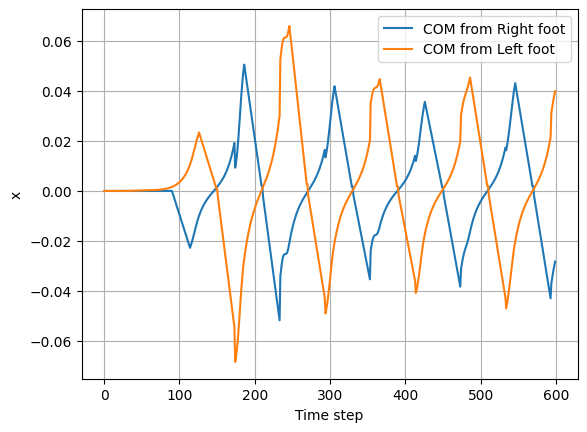

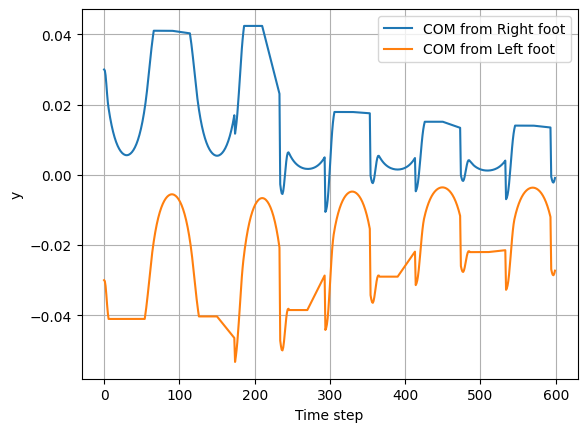

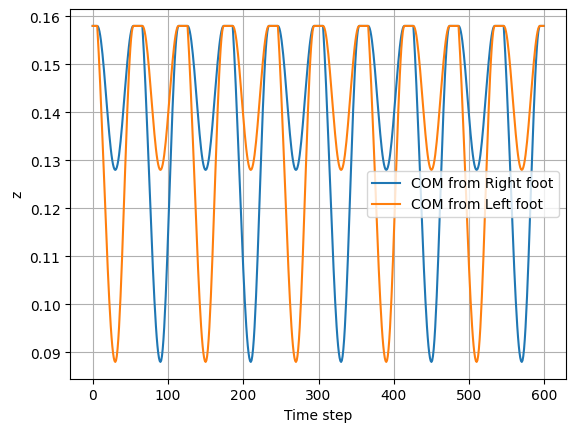

In [1053]:
# 時間軸（step）
t = range(len(com_right))

# 各成分を抽出
rx = [p[0] for p in com_right]
ry = [p[1] for p in com_right]
rz = [p[2] for p in com_right]

lx = [p[0] for p in com_left]
ly = [p[1] for p in com_left]
lz = [p[2] for p in com_left]

# -------- x --------
plt.figure()
plt.plot(t, rx, label="COM from Right foot")
plt.plot(t, lx, label="COM from Left foot")
plt.xlabel("Time step")
plt.ylabel("x")
plt.legend()
plt.grid()

# -------- y --------
plt.figure()
plt.plot(t, ry, label="COM from Right foot")
plt.plot(t, ly, label="COM from Left foot")
plt.xlabel("Time step")
plt.ylabel("y")
plt.legend()
plt.grid()

# -------- z --------
plt.figure()
plt.plot(t, rz, label="COM from Right foot")
plt.plot(t, lz, label="COM from Left foot")
plt.xlabel("Time step")
plt.ylabel("z")
plt.legend()
plt.grid()

plt.show()
